In [1]:
# import the required packages
from ema_workbench import (RealParameter,
                           CategoricalParameter,
                           BooleanParameter,
                           TimeSeriesOutcome,
                           ScalarOutcome,
                           Policy,
                           MultiprocessingEvaluator,
                           SequentialEvaluator,
                           save_results,
                           ema_logging)
from linnyr_connector import LinnyRModel_Botlek
import numpy as np

# for EMA Workbench stuff
if __name__ == '__main__':

    # enable info logging
    ema_logging.log_to_stderr(ema_logging.INFO)

    # define a list with the models
    model_list = [LinnyRModel_Botlek(name = 'Collective', 
                                     wd = './models', 
                                     model_file = 'test.lnr')]
                 # LinnyRModel_Botlek(name = 'Nouryon', 
                                    # wd = './models', 
                                    # model_file = 'botlek_model_nouryon.lnr'),
                 # LinnyRModel_Botlek(name = 'AirLiquide', 
                                    # wd = './models', 
                                    # model_file = 'botlek_model_airliquide.lnr'),
                 # LinnyRModel_Botlek(name = 'Huntsman', 
                                    # wd = './models', 
                                    # model_file = 'botlek_model_huntsman.lnr')]
    
    # for every model in the model list
    for model in model_list:

        # define the uncertain factors
        model.uncertainties = [RealParameter(name = 'Electricity price in 2030 (€/MWh)',
                                             variable_name = 'E day-ahead:Price',
                                             lower_bound = 36.0, 
                                             upper_bound = 80.0),
                               RealParameter(name = 'Gas price in 2030 (€/Nm3)',
                                             variable_name = 'natural gas market:Price',
                                             lower_bound = 0.16, 
                                             upper_bound = 0.32),
                               RealParameter(name = 'CO2 emission price in 2030 (€/ton)',
                                             variable_name = 'CO2 EUROPEAN EMISSION ALLOWANCES:StC',
                                             lower_bound = 21.0, 
                                             upper_bound = 80.0),
                               RealParameter(name = 'Hydrogen price in 2030 (€/Nm3)',
                                             variable_name = 'H2 markt:Price',
                                             lower_bound = 0.073, 
                                             upper_bound = 0.089),
                               RealParameter(name = 'NaOH 50% price in 2030 (€/ton)',
                                             variable_name = 'NaOH 50%:Price',
                                             lower_bound = 220.0, 
                                             upper_bound = 269.0),
                               RealParameter(name = 'Factor upward balancing electricity price (€/MWh)',
                                             variable_name = 'Unbal opregelen:Price',
                                             lower_bound = 0.7, 
                                             upper_bound = 1.3),
                               RealParameter(name = 'Factor downward balancing electricity price (€/MWh)',
                                             variable_name = 'Unbal afregelen:Price',
                                             lower_bound = 0.7, 
                                             upper_bound = 1.3),
                               RealParameter(name = 'Factor electricity supply imbalance market (MWh)',
                                             variable_name = 'Unbal afregelen:LB',
                                             lower_bound = 0.7, 
                                             upper_bound = 1.3),
                               RealParameter(name = 'Factor electricity demand imbalance market (MWh)',
                                             variable_name = 'Unbal opregelen:UB',
                                             lower_bound = 0.7, 
                                             upper_bound = 1.3),
                               RealParameter(name = 'E-boiler CAPEX (€/MW)',
                                             variable_name = 'Capex E-boiler:Price',
                                             lower_bound = 1.4*10**6, 
                                             upper_bound = 2.0*10**6),
                               RealParameter(name = 'E-boiler OPEX (€/MW/year)',
                                             variable_name = 'OPEX E-BOILER:Price',
                                             lower_bound = 2.8*10**3, 
                                             upper_bound = 4.0*10**3),
                               RealParameter(name = 'Steam Pipe CAPEX (€)',
                                             variable_name = 'CAPEX Steam Pipe:Price',
                                             lower_bound = 5.6*10**6, 
                                             upper_bound = 8.0*10**6)]

        # define the levers (Power-to-X alternatives)
        model.levers = [BooleanParameter(name = 'E-boiler',
                                         variable_name = 'e_boiler'),
                        BooleanParameter(name = 'Steam Pipe',
                                         variable_name = 'steam_pipe'),
                        BooleanParameter(name = 'Chlorine Storage',
                                         variable_name = 'chlorine_storage')]

        # define the outcomes
        model.outcomes = [ScalarOutcome(name = 'CF total',
                                        variable_name = 'CF total',
                                        function = np.sum),
                          ScalarOutcome(name = 'CF Air Liquide',
                                        variable_name = 'CF total',
                                        function = np.sum),
                          ScalarOutcome(name = 'CF Huntsman',
                                        variable_name = 'CF total',
                                        function = np.sum),
                          ScalarOutcome(name = 'CF Nouryon',
                                        variable_name = 'CF total',
                                        function = np.sum),
                          ScalarOutcome(name = 'CO2 emissions',
                                        variable_name = 'CO2 emission',
                                        function = np.max)]
    
    # define the full factorial set of policies with names
    policies = [Policy('None of the options', **{'Steam Pipe':False, 'E-boiler':False, 'Chlorine Storage':False}),
                Policy('Only Steam Pipe', **{'Steam Pipe':True, 'E-boiler':False, 'Chlorine Storage':False}),
                Policy('Only E-boiler', **{'Steam Pipe':False, 'E-boiler':True, 'Chlorine Storage':False}),
                Policy('Only Chlorine storage', **{'Steam Pipe':False, 'E-boiler':False, 'Chlorine Storage':True}),
                Policy('Steam Pipe & E-boiler', **{'Steam Pipe':True, 'E-boiler':True, 'Chlorine Storage':False}),
                Policy('Steam Pipe & Chlorine storage', **{'Steam Pipe':True, 'E-boiler':False, 'Chlorine Storage':True}),
                Policy('E-boiler & Chlorine storage', **{'Steam Pipe':False, 'E-boiler':True, 'Chlorine Storage':True}),
                Policy('All options', **{'Steam Pipe':True, 'E-boiler':True, 'Chlorine Storage':True})]
    
    # define the number of scenarios to be sampled
    scenarios = 1

    # run the models
    with MultiprocessingEvaluator(model_list) as evaluator:
         results = evaluator.perform_experiments(policies = policies, scenarios = scenarios)
    
    # save the results
    save_results(results, f'./results/test.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 8 policies * 1 model(s) = 8 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\909853\Documents\botlek_test\results\test.tar.gz


In [4]:
experiments, outcomes = results
experiments.to_csv('blabla.csv')

In [11]:
save_results(results, f'./results/test.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\909853\Documents\botlek_test\results\test.tar.gz


In [2]:
from ema_workbench import load_results
load_results('./results/test.tar.gz')

TypeError: data type "ob" not understood

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


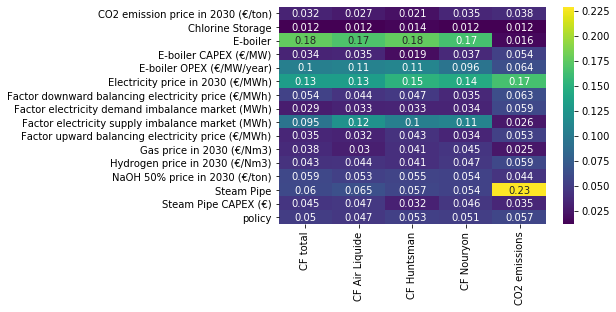

In [44]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns
import matplotlib.pyplot as plt

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
plot = sns.heatmap(fs, xticklabels = True, cmap='viridis', annot=True)
fig = plot.get_figure()
fig.savefig('fs_80_scenarios.png', dpi = 400, bbox_inches = "tight")